In [1]:
%load_ext autoreload
%autoreload 2
from network import *

In [2]:
# 필요한 라이브러리 불러오기
from sklearn.datasets import load_iris
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

def one_hot_encode(y):
    encoder = OneHotEncoder(sparse=False)
    y_reshaped = y.reshape(-1, 1)
    return encoder.fit_transform(y_reshaped)

# Iris 데이터셋 불러오기
iris = load_digits()
X = iris.data
y = iris.target
y = one_hot_encode(y)
# 데이터셋을 train과 test로 분할 (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 결과 출력
print(f'Training set size: {X_train.shape[0]}')
print(f'Test set size: {X_test.shape[0]}')


Training set size: 1437
Test set size: 360


c:\Users\coex0\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


## 5.7.3 오차역전파법으로 구한 기울기 검증하기

In [ ]:
network = TwoLayerNetwork(X_train[0].size, 50, y_train[0].size)

In [ ]:
X_batch = X_train[:3]
y_batch = y_train[:3]

grad_numerical = network.numerical_gradient(X_batch, y_batch)
grad_backprop = network.gradient(X_batch, y_batch)

In [ ]:
network.params

In [ ]:
for key in grad_numerical.keys():
    diff = np.average(np.abs(grad_backprop[key] - grad_numerical[key]))
    print(key + ":" + str(diff))

## 5.7.4 오차역전파법을 사용한 학습 구현하기

### Using gradient descent

0.1336116910229645 0.1388888888888889
0.789839944328462 0.7861111111111111
0.8747390396659708 0.85
0.9109255393180237 0.8944444444444445
0.9380654140570633 0.9027777777777778
0.941544885177453 0.9111111111111111
0.9582463465553236 0.9083333333333333
0.9561586638830898 0.9222222222222223
0.9679888656924147 0.9305555555555556
0.9735560194850382 0.9305555555555556
0.9791231732776617 0.9277777777777778
0.9826026443980515 0.9277777777777778
0.9846903270702854 0.9333333333333333
0.988169798190675 0.9333333333333333
0.988169798190675 0.9388888888888889
0.9853862212943633 0.9416666666666667
0.9902574808629089 0.9416666666666667
0.9909533750869868 0.9555555555555556
0.9916492693110647 0.95
0.9902574808629089 0.9472222222222222


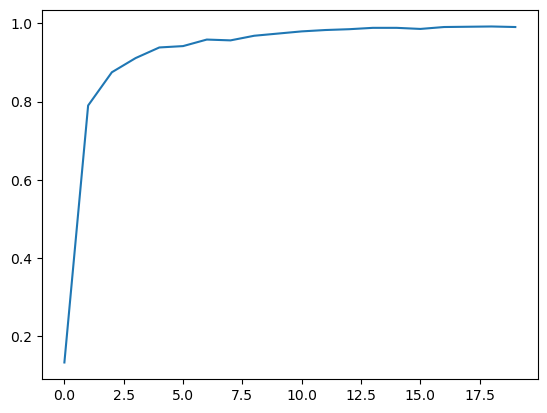

In [6]:
network = TwoLayerNetwork(X_train[0].size, 200, y_train[0].size)

num_iter = 200
train_size = X_train.shape[0]
batch_size = 100
learning_rate = 0.03
train_loss_log = []
train_acc_log = []
test_acc_log = []

iter_per_epoch = max(train_size / batch_size, 1)

for i in range(num_iter):
    batch_mask = np.random.choice(train_size, batch_size)
    X_batch = X_train[batch_mask]
    y_batch = y_train[batch_mask]
    
    grad = network.gradient(X_batch, y_batch)
    for key in list(network.params.keys()): # gradient descent
        network.params[key] -= learning_rate * grad[key]
    
    loss = network.loss(X_batch, y_batch)
    train_loss_log.append(loss)
    
    if i % 10 == 0:
        train_acc = network.accuracy(X_train, y_train)
        test_acc = network.accuracy(X_test, y_test)
        train_acc_log.append(train_acc)
        test_acc_log.append(test_acc)
        print(train_acc, test_acc)
        
import matplotlib.pyplot as plt
plt.plot(np.arange(len(train_acc_log)), np.array(train_acc_log))
plt.show()

In [7]:
network.params

{'W1': array([[ 0.4379728 , -0.20857893,  0.29179183, ...,  0.11255738,
         -0.14578025,  0.20450502],
        [-0.29526624,  0.13823545,  0.05339213, ...,  0.37823966,
          0.08756201,  0.23715737],
        [-0.1909677 , -0.21978025, -0.40860727, ...,  0.2772081 ,
         -0.05466561, -0.33030441],
        ...,
        [ 0.04822655, -0.29067315, -0.0234419 , ...,  0.19432196,
         -0.12016954,  0.05810673],
        [ 0.2227736 ,  0.18698956, -0.2647049 , ..., -0.28806733,
          0.09760798, -0.05881634],
        [-0.36087428,  0.28010003, -0.05643055, ..., -0.58133924,
         -0.06880666,  0.24086007]]),
 'b1': array([-1.31790072e-02, -5.28421958e-04, -4.15040782e-03, -1.78065074e-02,
        -6.30363322e-03, -4.65551271e-04, -6.30726684e-04, -9.72367922e-03,
        -4.37360611e-03, -8.03195213e-03, -9.20595156e-04, -1.62051095e-03,
         1.23048995e-04,  1.83017426e-03, -3.41404966e-03, -2.22177166e-03,
        -4.43757714e-03, -4.32285311e-03, -2.20788728e-04

2


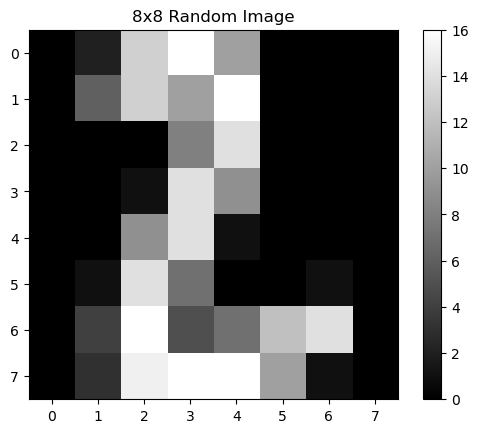

In [33]:
test = X_test[4]
print(network.infer(test))
plt.imshow(test.reshape(8, 8), cmap='gray')  # cmap을 'gray'로 설정하여 흑백 이미지로 표시
plt.colorbar()  # 색상 막대를 추가합니다
plt.title("8x8 Random Image")
plt.show()

In [25]:
info = {
    "Affain1":(X_train[0].size, 200),
    "ReLU1":(200, 200),
    "Affain2":(200, y_train[0].size),
    "SoftmaxWithLoss":(y_train[0].size, y_train[0].size)
}
network = MultiLayerNetwork(info=info)
network.fit(X_train, y_train, batch_size=100, epoch=200, learning_rate=0.03)

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190


'final loss : 0.008201283913284401 / final train accuracy : 0.9979123173277662'

### Using moment

In [8]:
import copy
network = TwoLayerNetwork(X_train[0].size, 50, y_train[0].size)

num_iter = 1000
train_size = X_train.shape[0]
batch_size = 100
learning_rate = 0.03
alpha = 0.5
moment = copy.deepcopy(network.params)
for key in list(moment.keys()):
    moment[key] *= 0

train_loss_log = []
train_acc_log = []
test_acc_log = []
grad = None
for i in range(num_iter):
    batch_mask = np.random.choice(train_size, batch_size)
    X_batch = X_train[batch_mask]
    y_batch = y_train[batch_mask]
    
    grad = network.gradient(X_batch, y_batch)
    for key in list(network.params.keys()): # gradient descent
         moment[key] = alpha*moment[key] - learning_rate*grad[key]
         network.params[key] += moment[key]
    
    loss = network.loss(X_batch, y_batch)
    train_loss_log.append(loss)
    
    if i % 10 == 0:
        train_acc = network.accuracy(X_train, y_train)
        test_acc = network.accuracy(X_test, y_test)
        train_acc_log.append(train_acc)
        test_acc_log.append(test_acc)
        print(train_acc, test_acc)
        
plt.plot(np.arange(len(train_acc_log)), np.array(train_acc_log))
plt.show()

0.09881697981906751 0.07222222222222222
0.44606819763395966 0.4583333333333333
0.5963813500347948 0.6444444444444445
0.6520528879610299 0.6916666666666667
0.7223382045929019 0.7444444444444445
0.7842727905358385 0.8055555555555556
0.8155880306193458 0.8333333333333334
0.8357689631176062 0.85
0.848990953375087 0.8583333333333333
0.8587334725121781 0.8527777777777777
0.8907446068197634 0.8694444444444445
0.9046624913013221 0.8861111111111111
0.8997912317327766 0.8944444444444445
0.8810020876826722 0.8805555555555555
0.9102296450939458 0.9166666666666666
0.919276270006959 0.9027777777777778
0.9199721642310369 0.9138888888888889
0.9290187891440501 0.9138888888888889
0.9380654140570633 0.9305555555555556
0.929714683368128 0.925
0.9450243562978428 0.9305555555555556
0.954070981210856 0.9305555555555556
0.9512874043145442 0.9222222222222223
0.954070981210856 0.9444444444444444
0.9638135003479471 0.9361111111111111
0.9610299234516354 0.9416666666666667
0.9610299234516354 0.9388888888888889
0.9

NameError: name 'plt' is not defined

### Using learning rate decay

In [ ]:
network = TwoLayerNetwork(X_train[0].size, 50, y_train[0].size)
num_iter = 1000
train_size = X_train.shape[0]
batch_size = 100
initial_learning_rate = 0.05
learning_rate = initial_learning_rate
learning_rate_decay = 0.99  # learning rate decay factor
train_loss_log = []
train_acc_log = []
test_acc_log = []

iter_per_epoch = max(train_size / batch_size, 1)

for i in range(num_iter):
    batch_mask = np.random.choice(train_size, batch_size)
    X_batch = X_train[batch_mask]
    y_batch = y_train[batch_mask]
    
    grad = network.gradient(X_batch, y_batch)
    for key in list(network.params.keys()): # gradient descent
        network.params[key] -= learning_rate * grad[key]
    
    loss = network.loss(X_batch, y_batch)
    train_loss_log.append(loss)
    
    if i % iter_per_epoch == 0:
        learning_rate *= learning_rate_decay  # decay the learning rate
    
    if i % 10 == 0:
        train_acc = network.accuracy(X_train, y_train)
        test_acc = network.accuracy(X_test, y_test)
        train_acc_log.append(train_acc)
        test_acc_log.append(test_acc)
        print(train_acc, test_acc)
        
plt.plot(np.arange(len(train_acc_log)), np.array(train_acc_log))
plt.show()
